# Uplift Modeling X5

В даной работе я попытался решить задачу uplift моделирования на [данных X5](https://www.kaggle.com/competitions/2021-uplift-modeling/data) по поиску клиентов, которые не совершили бы target без получения некоторого treatment. В данной работе будет использована трансформация классов.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [2]:
warnings.filterwarnings('ignore')

Первый файл содержит в себе общую информацию о клиентах

In [3]:
client_data = pd.read_csv('datasets/x5_uplift/clients2.csv')
client_data = client_data.drop('client_id.1', axis=1)
client_data.head(3)

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U


Второй файл содержит информацию о target клиента и взаимодействии с ним

In [4]:
train_data = pd.read_csv('datasets/x5_uplift/train.csv')
train_data.head(3)

,client_id,treatment_flg,target
0,ad6561e2d8,1,1
1,7c1ccbf93f,1,1
2,b58fadcab6,1,1


Тестовый файл содержит в себе id клиентов, для которых необходимо предсказать совершит ли он покупку только с тритментом 

In [5]:
test_data = pd.read_csv('datasets/x5_uplift/test.csv')
test_data.head(3)

,client_id
0,a9a604ed6e
1,ebd7360016
2,908cd9b8e8


Посоледние два файла содержат инфформацию о транзакциях клиентов, так как они большие по размеру, то сразу загрузим некоторые из их колонок в более легком формате.

In [6]:
train_punch = \
pd.read_csv('datasets/x5_uplift/train_purch.csv',
           dtype={'express_points_received': np.int32,\
                 'regular_points_spent': np.int32,\
                 'express_points_spent': np.int32,
                 'product_quantity': np.int32},\
           parse_dates=['transaction_datetime'])
train_punch.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0,0,0,1007.0,54a4a11a29,9a80204f78,2,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0,0,0,1007.0,54a4a11a29,da89ebd374,1,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0,0,0,1007.0,54a4a11a29,0a95e1151d,1,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0,0,0,1007.0,54a4a11a29,4055b15e4a,2,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0,0,0,1007.0,54a4a11a29,a685f1916b,1,22.0,NaN


In [7]:
transaction_date = train_punch[['transaction_id', 'transaction_datetime']].copy()

In [8]:
numeric_columns = ['regular_points_received', 'express_points_received', 'regular_points_spent', \
                   'express_points_spent', 'purchase_sum']

In [9]:
train_punch.drop(['transaction_datetime', 'store_id', 'product_id', \
                  'trn_sum_from_red', 'product_quantity', 'trn_sum_from_iss'], axis=1, inplace=True)

In [10]:
train_punch = train_punch.groupby(['client_id', 'transaction_id'])[numeric_columns].mean().reset_index()
train_punch.head(3)

,client_id,transaction_id,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum
0,000012768d,6a0e96d0bc,8.0,0.0,0.0,0.0,803.0
1,000012768d,7e3e2e3984,10.0,0.0,0.0,0.0,1007.0
2,000012768d,b34f23306e,2.0,0.0,0.0,0.0,419.0


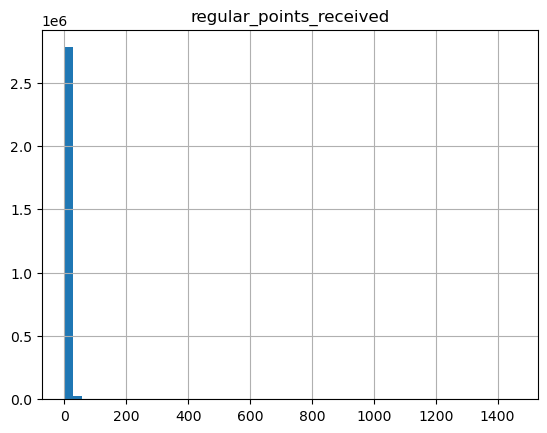

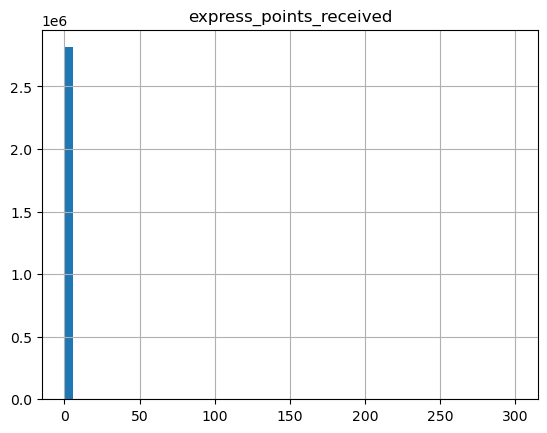

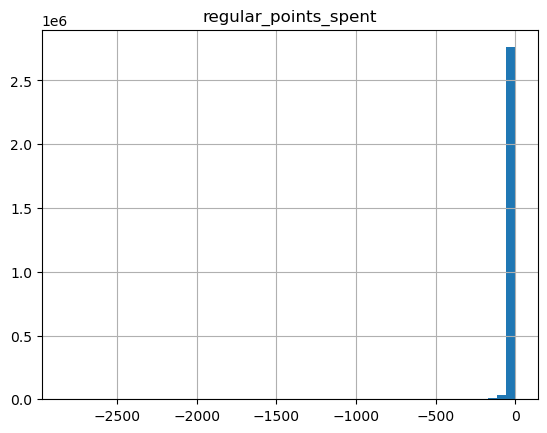

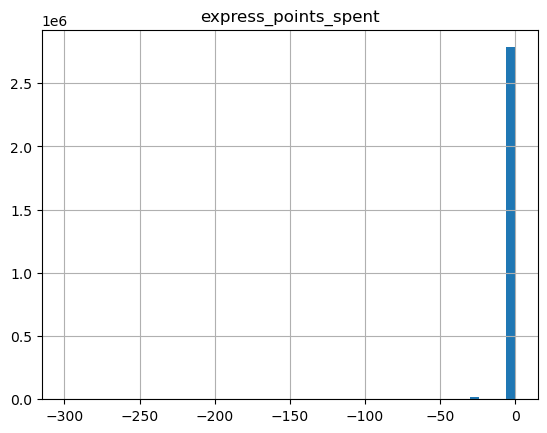

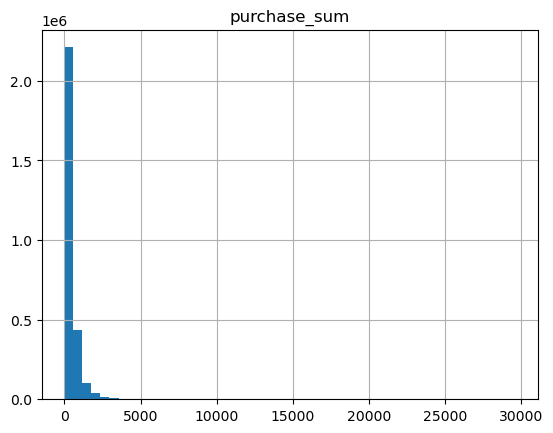

In [11]:
for col in numeric_columns:
    train_punch[col].hist(bins=50)
    plt.title(col)
    plt.show()

Гистограммы кажутся будто с выбросами, однако это не так, потому что потратить 2000 баллов за покупку вполне реально, много покупок без списания баллов, так как пользователи просто копят баллы.

In [12]:
train_punch = train_punch.merge(transaction_date, on='transaction_id', how='left')

In [13]:
max_date = train_punch['transaction_datetime'].max()
unactive_days = (max_date - train_punch['transaction_datetime']).dt.days
client_unactivity = pd.DataFrame(train_punch['client_id']).join(pd.DataFrame(unactive_days))
client_unactivity = client_unactivity.groupby('client_id')['transaction_datetime'].max().\
reset_index()
client_unactivity = client_unactivity.rename(columns={'transaction_datetime':'unactive_days'})

In [14]:
train_punch.drop(['transaction_id', 'transaction_datetime'], axis=1, inplace=True)
train_punch = train_punch.groupby('client_id')[numeric_columns].sum().reset_index()
train_punch = train_punch.merge(client_unactivity, on='client_id')
train_punch.head()

,client_id,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,unactive_days
0,000012768d,392.7,0.0,0.0,0.0,40809.00,107
1,000036f903,348.3,360.0,0.0,0.0,58765.00,110
2,0001f552b0,552.2,0.0,0.0,0.0,47974.34,114
3,00020e7b18,6088.0,0.0,-2674.0,-330.0,558970.46,115
4,000220a0a7,896.6,0.0,0.0,0.0,69487.58,97


In [15]:
test_punch = \
pd.read_csv('datasets/x5_uplift/test_purch.csv',
           dtype={'express_points_received': np.int32,\
                 'regular_points_spent': np.int32,\
                 'express_points_spent': np.int32,
                 'product_quantity': np.int32},
           parse_dates=['transaction_datetime'])

In [16]:
test_transaction_date = test_punch[['transaction_datetime', 'transaction_id']].copy()

In [17]:
test_punch.drop(['transaction_datetime', 'store_id', 'product_id', \
                  'trn_sum_from_red', 'product_quantity', 'trn_sum_from_iss'], axis=1, \
                inplace=True)

In [18]:
test_punch = test_punch.groupby(['client_id', 'transaction_id'])\
[numeric_columns].mean().reset_index()

In [19]:
test_punch = test_punch.merge(test_transaction_date, on='transaction_id', how='left')

In [20]:
max_date_test = test_punch['transaction_datetime'].max()
unactive_days_test = (max_date_test - test_punch['transaction_datetime']).dt.days
client_unactivity_test = pd.DataFrame(test_punch['client_id']).\
join(pd.DataFrame(unactive_days_test))
client_unactivity_test = client_unactivity_test.\
groupby('client_id')['transaction_datetime'].max().reset_index()
client_unactivity_test = client_unactivity_test.rename\
(columns={'transaction_datetime':'unactive_days'})

In [21]:
test_punch = test_punch.groupby('client_id')[numeric_columns].sum().reset_index()
test_punch = test_punch.merge(client_unactivity_test, on='client_id')
test_punch.head(3)

,client_id,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,unactive_days
0,00010925a5,163.0,0.0,-85.0,0.0,28494.00,113
1,00035a21d9,259.2,0.0,-104.0,-390.0,17545.52,37
2,00038f9200,351.7,0.0,-87.0,0.0,37684.00,101


Нас интересуют только клиенты:
1) которые не совершили покупку и при этом на них был нулевой treatment
2) которые совершили покупку при условии treatment

Ниже представлена трансформация классов для данной задачи.

![Class Transformation](https://habrastorage.org/r/w1560/webt/d0/l7/kb/d0l7kb2vkvvzdrcnnqq-gihfqgu.png)

In [22]:
train_df = train_data.merge(client_data, on='client_id', how='left')
train_df = train_df.merge(train_punch, on='client_id', how='left')
train_df.drop('client_id', axis=1, inplace=True)
train_df['gender'] = train_df['gender'].apply(lambda x: 1 if x =='F' else 0)
train_df['first_issue_date'] = pd.to_datetime(train_df['first_issue_date'])
train_df['first_redeem_date'] = pd.to_datetime(train_df['first_redeem_date'])
train_df['first_issue_month'] = train_df['first_issue_date'].dt.month
train_df['first_issue_year'] = train_df['first_issue_date'].dt.year
train_df['first_issue_year'] = train_df['first_issue_year'] - train_df['first_issue_year'].min()
# то же самое с first_redeem_date
train_df['first_redeem_month'] = train_df['first_redeem_date'].dt.month
train_df['first_redeem_year'] = train_df['first_redeem_date'].dt.year
train_df['first_redeem_year'] = train_df['first_redeem_year'] - train_df['first_redeem_year'].min()
# class transformation target
train_df['bought'] = train_df['target'] * train_df['treatment_flg'] + \
(1 - train_df['target']) * (1 - train_df['treatment_flg'])
train_df['bought'] = train_df['bought'].apply(lambda x: 1 if x == 1 else 0)

train_df = train_df.drop(['first_issue_date', 'first_redeem_date', 'target', 'treatment_flg'], axis=1)

train_df.head(3)

,age,gender,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,unactive_days,first_issue_month,first_issue_year,first_redeem_month,first_redeem_year,bought
0,50,1,729.0,0.0,-576.0,0.0,78849.40,115,12,0,5.0,1.0,1
1,24,1,96.2,0.0,0.0,0.0,7833.00,27,11,0,2.0,1.0,1
2,36,0,757.5,0.0,-2781.0,0.0,114288.48,116,11,0,9.0,1.0,1


In [23]:
train_df.dropna(inplace=True)
train_df.describe()

,age,gender,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,unactive_days,first_issue_month,first_issue_year,first_redeem_month,first_redeem_year,bought
count,127673.000000,127673.000000,127673.000000,127673.000000,127673.000000,127673.000000,1.276730e+05,127673.000000,127673.000000,127673.000000,127673.000000,127673.000000,127673.000000
mean,46.524872,0.374903,970.110759,7.819547,-662.330211,-39.661949,9.377220e+04,99.432934,7.144322,0.436819,6.662818,0.969774,0.517580
std,55.493654,0.484100,1906.658270,115.950475,1960.469945,124.430296,1.660606e+05,24.844875,3.140391,0.594865,3.693947,0.731864,0.499693
min,-7491.000000,0.000000,0.000000,0.000000,-126989.000000,-9210.000000,3.870000e+00,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,34.000000,0.000000,156.900000,0.000000,-558.000000,0.000000,2.061536e+04,96.000000,5.000000,0.000000,3.000000,0.000000,0.000000
50%,46.000000,0.000000,416.800000,0.000000,-110.000000,0.000000,4.730692e+04,110.000000,7.000000,0.000000,7.000000,1.000000,1.000000
75%,59.000000,1.000000,1016.000000,0.000000,0.000000,0.000000,1.023496e+05,115.000000,10.000000,1.000000,10.000000,2.000000,1.000000
max,1852.000000,1.000000,97040.600000,11100.000000,0.000000,0.000000,9.315100e+06,117.000000,12.000000,2.000000,12.000000,2.000000,1.000000


In [24]:
test_df = test_data.merge(client_data, on='client_id', how='left')
test_df = test_df.merge(test_punch, on='client_id', how='left')
test_df.drop('client_id', axis=1, inplace=True)
test_df['gender'] = test_df['gender'].apply(lambda x: 1 if x =='F' else 0)
test_df['first_issue_date'] = pd.to_datetime(test_df['first_issue_date'])
test_df['first_redeem_date'] = pd.to_datetime(test_df['first_redeem_date'])
test_df['first_issue_month'] = test_df['first_issue_date'].dt.month
test_df['first_issue_year'] = test_df['first_issue_date'].dt.year
# то же самое с first_redeem_date
test_df['first_redeem_month'] = test_df['first_redeem_date'].dt.month
test_df['first_redeem_year'] = test_df['first_redeem_date'].dt.year

test_df = test_df.drop(['first_issue_date', 'first_redeem_date'], axis=1)

test_df.head(3)

,age,gender,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,unactive_days,first_issue_month,first_issue_year,first_redeem_month,first_redeem_year
0,36,1,466.8,0.0,0.0,0.0,33702.70,98,9,2018,NaN,NaN
1,63,1,173.3,0.0,-45.0,0.0,24998.71,115,7,2017,9.0,2017.0
2,49,1,219.1,0.0,-179.0,0.0,37147.95,114,3,2018,7.0,2018.0


In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60012 entries, 0 to 60011
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      60012 non-null  int64  
 1   gender                   60012 non-null  int64  
 2   regular_points_received  60012 non-null  float64
 3   express_points_received  60012 non-null  float64
 4   regular_points_spent     60012 non-null  float64
 5   express_points_spent     60012 non-null  float64
 6   purchase_sum             60012 non-null  float64
 7   unactive_days            60012 non-null  int64  
 8   first_issue_month        60012 non-null  int64  
 9   first_issue_year         60012 non-null  int64  
 10  first_redeem_month       54820 non-null  float64
 11  first_redeem_year        54820 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 6.0 MB


In [26]:
test_df.loc[test_df['first_redeem_year'].isna(), 'first_redeem_year'] = \
test_df.loc[~test_df['first_redeem_year'].isna(), 'first_redeem_year'].mean()
test_df.loc[test_df['first_redeem_month'].isna(), 'first_redeem_month'] = \
test_df.loc[~test_df['first_redeem_month'].isna(), 'first_redeem_month'].mean()
test_df.loc[(test_df['age'] <= 0) | (test_df['age'] >= 90), 'age'] = \
test_df.loc[(test_df['age'] > 0) & (test_df['age'] < 90), 'age'].mean()

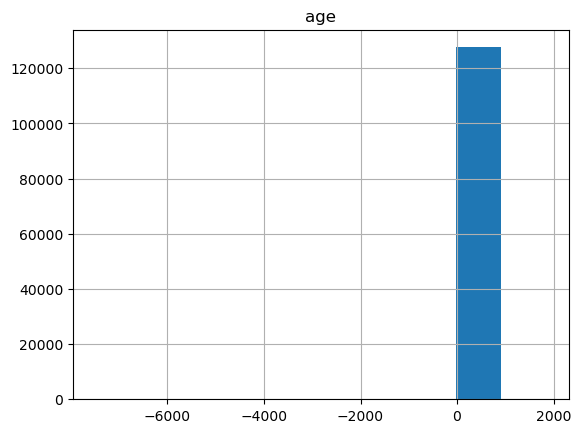

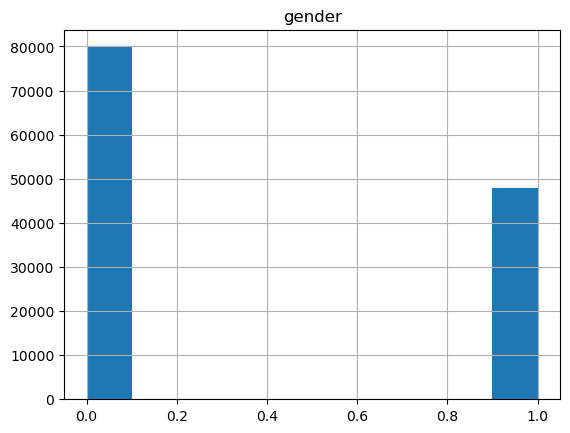

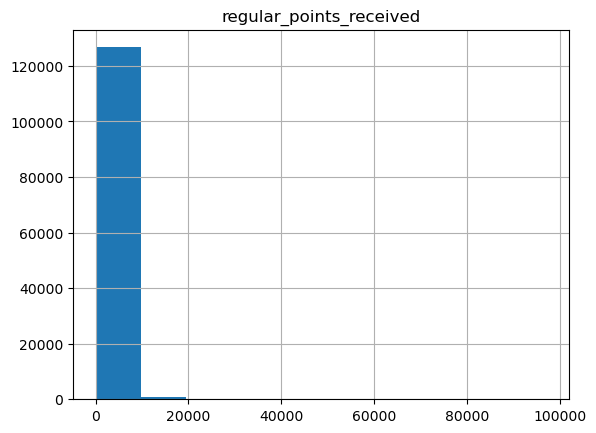

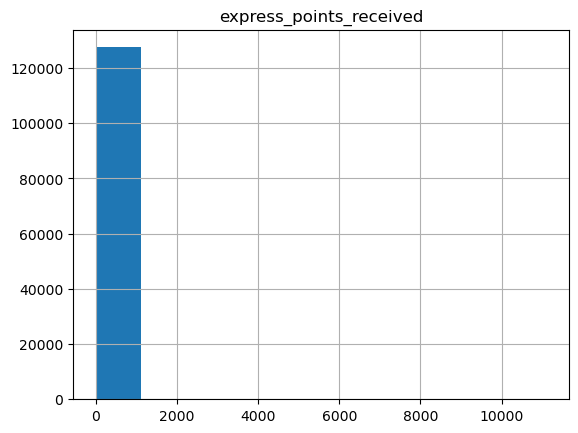

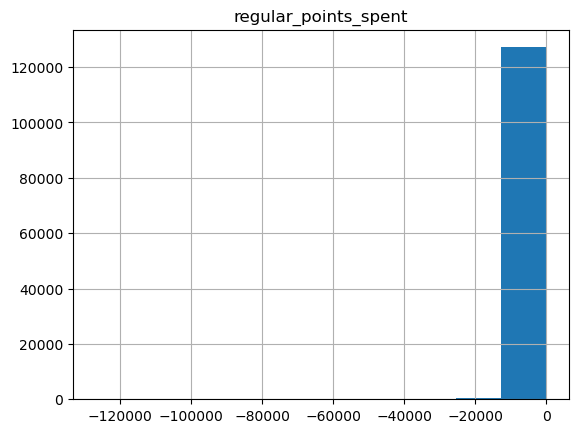

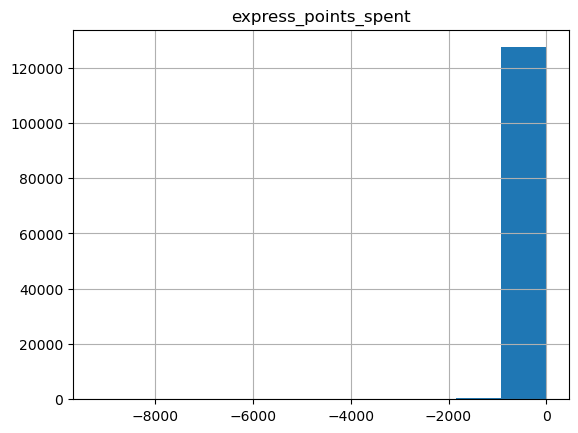

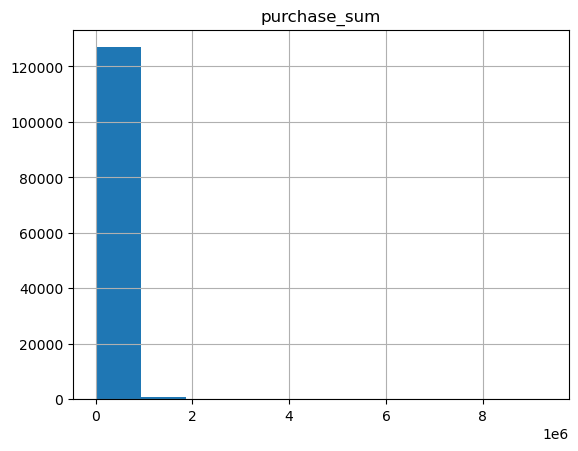

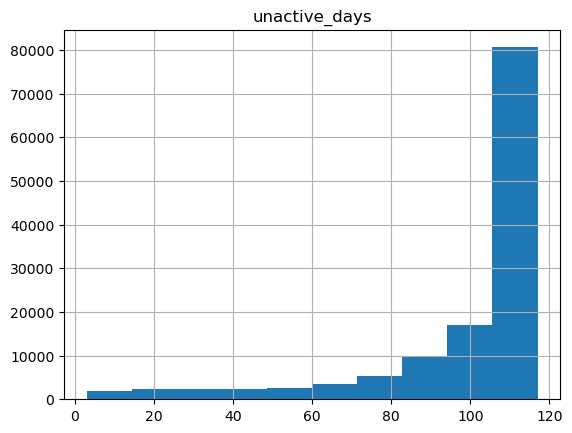

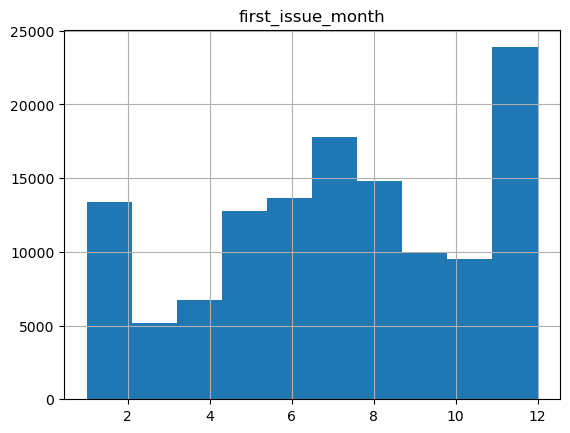

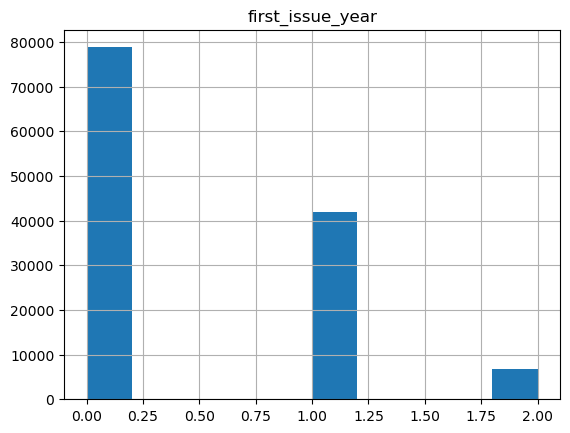

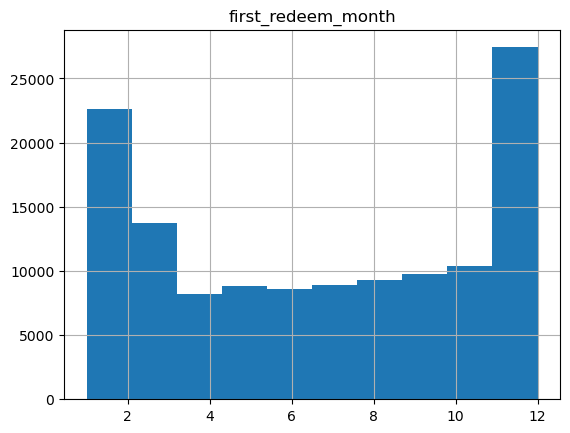

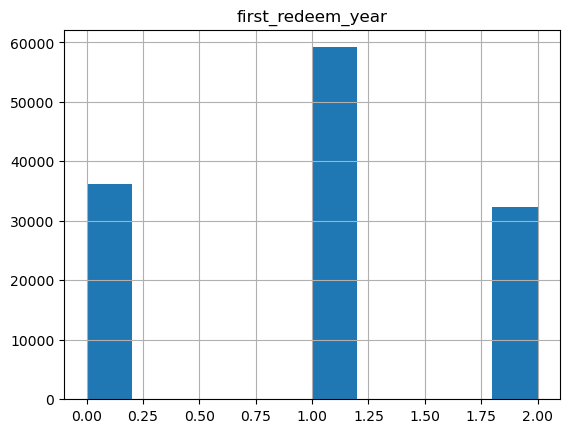

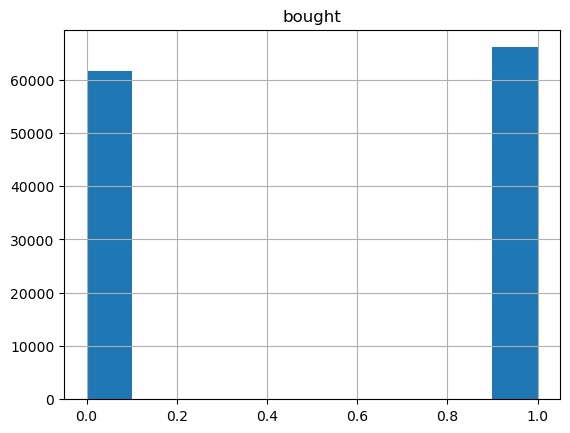

In [27]:
for col in train_df.columns:
    train_df[col].hist()
    plt.title(col)
    plt.show()

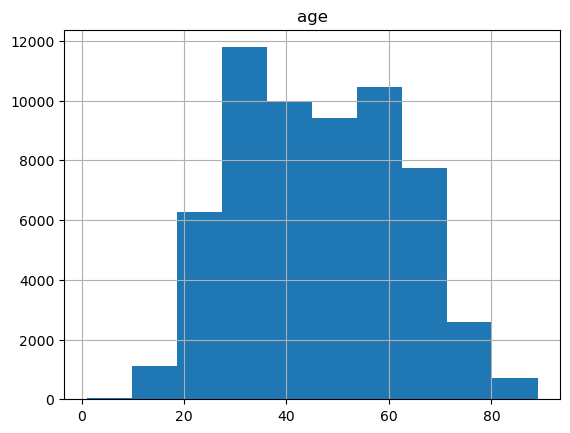

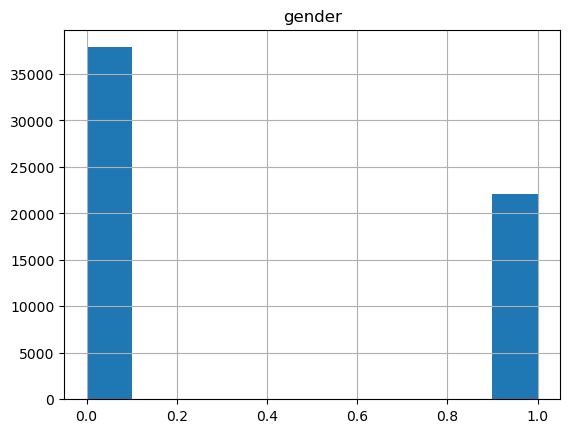

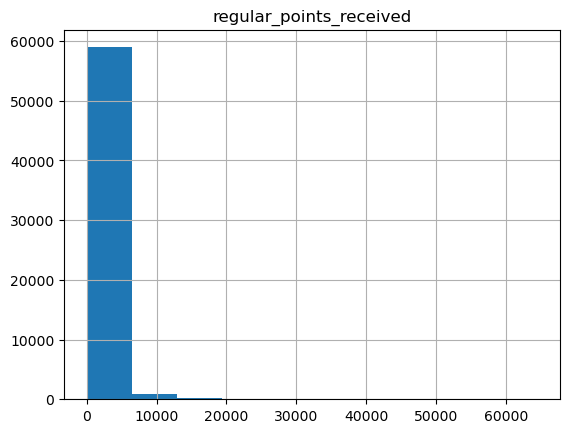

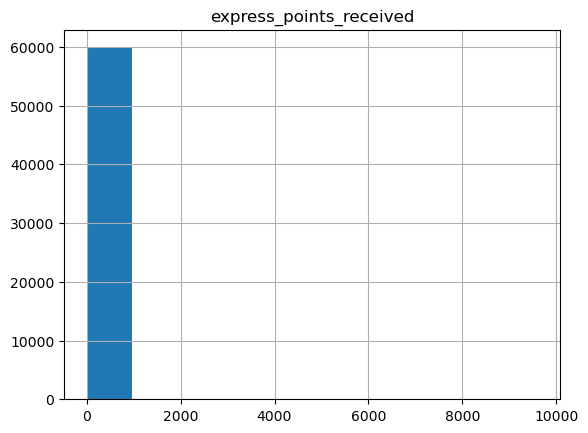

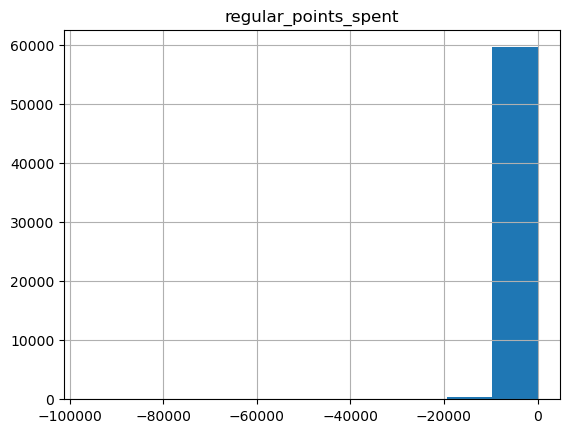

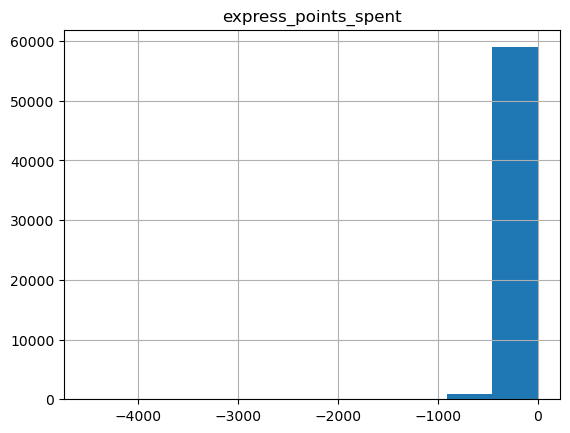

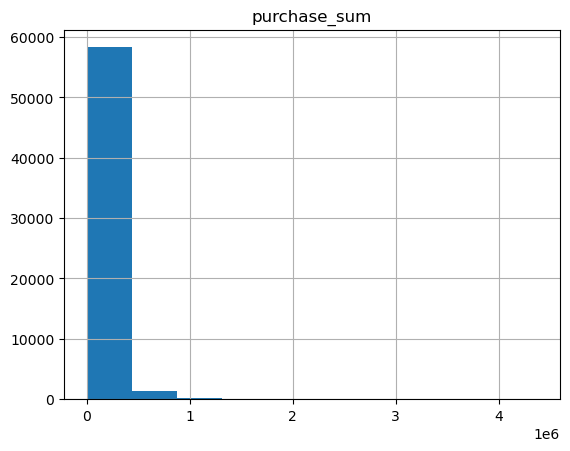

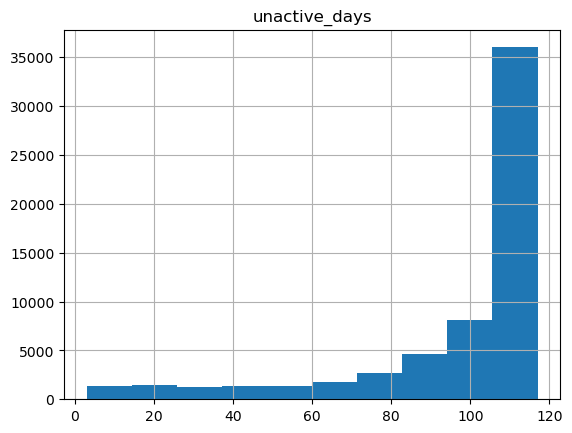

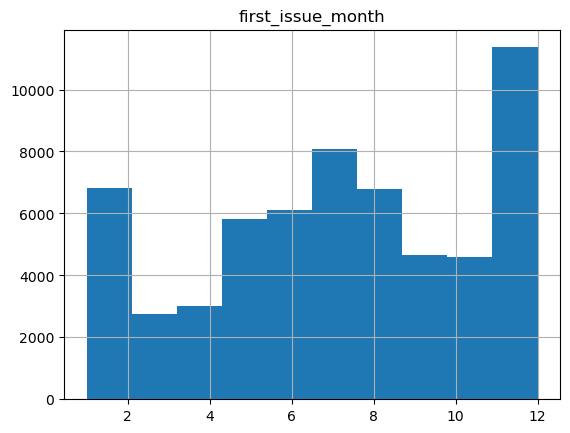

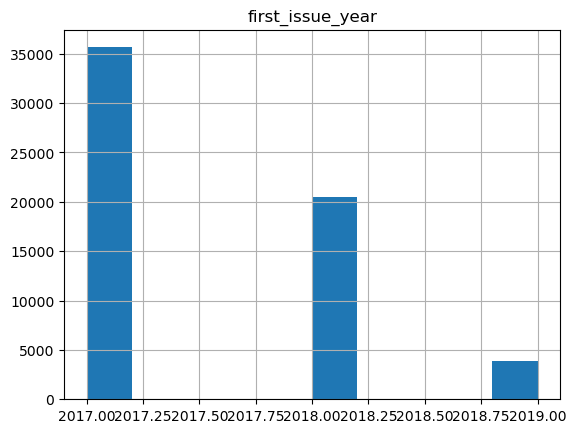

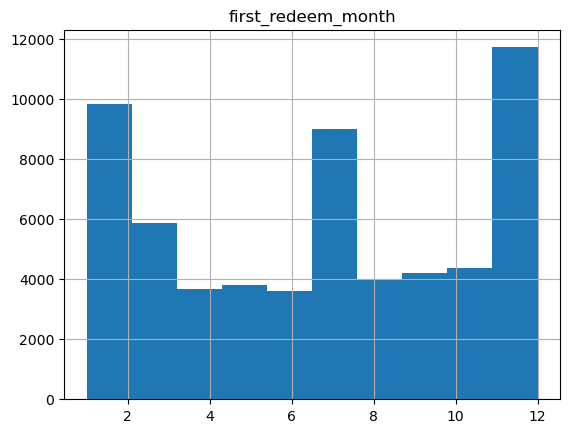

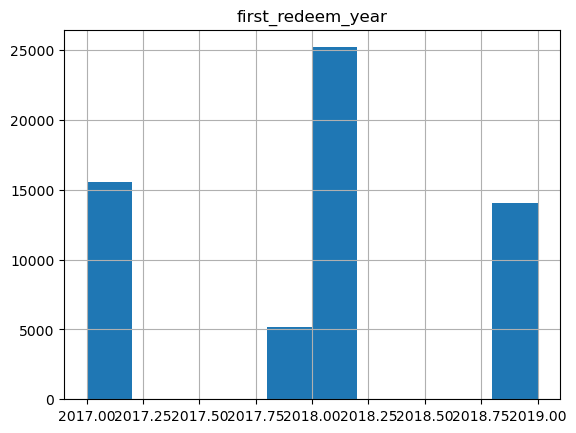

In [28]:
for col in test_df.columns:
    test_df[col].hist()
    plt.title(col)
    plt.show()

In [29]:
train_df = train_df[(train_df['age'] > 0) & (train_df['age'] < 90)]

<AxesSubplot: >

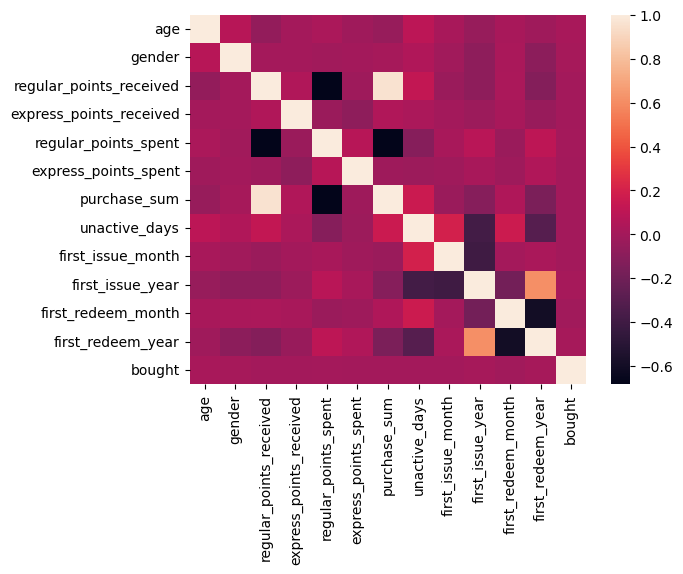

In [30]:
sns.heatmap(train_df.corr(), )

Видим сильную корреляцию стоимости покупки и накопленных баллов. Но мы не будем строить линейную регрессию, поэтому данная проблема не помешает ошибкой мультиколлинеарности.

## Train

In [31]:
X_train, X_val, y_train, y_val = \
train_test_split(train_df.drop('bought', axis=1), train_df['bought'], test_size=0.2)

### CatBoost 🐈 

In [32]:
cat = CatBoostClassifier(iterations=1000, verbose=False)
cat.fit(X_train, y_train)

In [33]:
2 * roc_auc_score(y_val, cat.predict_proba(X_val)[:, 1]) - 1

0.04131690986283765

### XGBoost

In [34]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [35]:
2 * roc_auc_score(y_val, xgb.predict_proba(X_val)[:, 1]) - 1

0.038059038325223504

### Random Forest

In [36]:
forest = RandomForestClassifier(n_estimators=300, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1)

In [37]:
2 * roc_auc_score(y_val, forest.predict_proba(X_val)[:, 1]) - 1

0.02911414069614504

Лушей моделью оказался catboost, дающий gini = 0.041. Посмотрим на важность признаков в ней

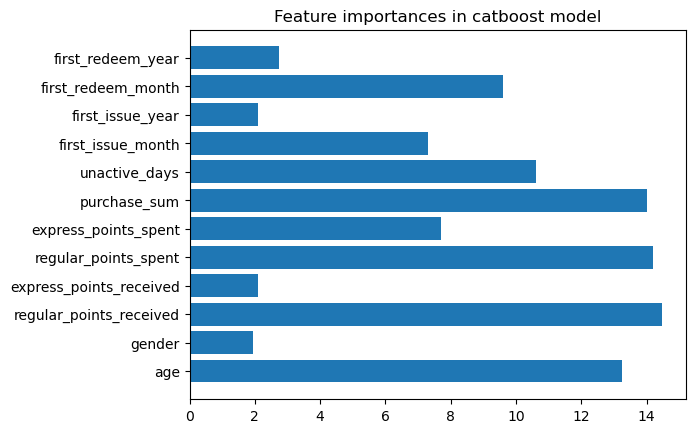

In [38]:
plt.barh(test_df.columns, width=cat.get_feature_importance())
plt.title('Feature importances in catboost model')
plt.show()

### Predictions

In [39]:
test_data['pred'] = cat.predict_proba(test_df)[:, 1]
test_data.to_csv('Downloads/x5_uplift_submission.csv', index=False)

### Вывод

В данной работе была решена задача uplift моделирования с использование трансформации классов. Были предобработы данные, созданы новые признаки, положительно повлиявшие на результаты предсказаний. Лучшей моделью оказался catboost, дающий на валидационных данный gini = 0.041.